In [3]:
%matplotlib inline

In [48]:
# imports & constants
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


MAX_VALS = 4*24*7 # 4 measurements per hour, 24 hours in a day
PATH_PREFIX = os.path.join(".", "dataset_live")
DATASET_ORIGINAL = os.path.join(PATH_PREFIX, "original")
DATASET_EXPANDED = os.path.join(PATH_PREFIX, "expanded")

ori_data = {
    "load_energy_meter": os.path.join(DATASET_ORIGINAL, "load_pwr.csv"),
    "common_services": os.path.join(DATASET_ORIGINAL, "cserv_pwr.csv"),
    "pv_generation": os.path.join(DATASET_ORIGINAL, "pv_pwr.csv"),
    "meters_index": os.path.join(DATASET_ORIGINAL, "dataset_index.csv"),
    "support": os.path.join(PATH_PREFIX, "HackTheElectron dataset support data.xlsx")
}

exp_data = {
    "load_energy_meter": os.path.join(DATASET_EXPANDED, "load_pwr.csv"),
    "common_services": os.path.join(DATASET_EXPANDED, "cserv_pwr.csv"),
    "pv_generation": os.path.join(DATASET_EXPANDED, "pv_pwr.csv"),
    "meters_index": os.path.join(DATASET_EXPANDED, "dataset_index.csv"),
    "building": os.path.join(DATASET_EXPANDED, "building_type.csv"),
    "tariffs": os.path.join(DATASET_EXPANDED, "tariffs.csv"),
    "support": os.path.join(PATH_PREFIX, "HackTheElectron dataset support data.xlsx")
}


In [49]:
# reading original data

df_dataset_index = pd.read_csv(ori_data['meters_index'],sep=';', encoding="latin1")
df_load = pd.read_csv(ori_data['load_energy_meter'],sep=';')
df_load = df_load.drop(columns="Unnamed: 0") # dropping meter ID (??)
df_load["time_datetime"]=pd.to_datetime(df_load.Time)
df_load = df_load.sort_values("time_datetime")


columns_of_interest = list(df_load.columns)
columns_of_interest.remove("Time")
columns_of_interest.remove("time_datetime")
for column_meter in columns_of_interest:
    # transforming from W to kWh
    df_load[column_meter] = df_load[column_meter]/4
    values = np.array(df_load[column_meter])
    mean, std = np.mean(values[:MAX_VALS]), np.std(values[:MAX_VALS])
    # z-nromalizing
    df_load[column_meter] = (df_load[column_meter] - mean) / std
    
    

# df_load.head()
# df_dataset_index.head()

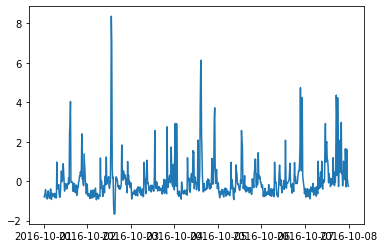

In [50]:
# testing with one meter data


x=df_load[["time_datetime"]][:MAX_VALS].values

y=df_load[["meter_1"]][:MAX_VALS].values

plt.plot(x,y)


# next steps

# z-normalize time series (all of them, and keep record of mean/var)

# experimenting with sax hehe



In [ ]:
# reading expanded data


